In [80]:
# back to project root
%cd ~/research

import argparse
import gc
import os
import sys
import time
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import yaml
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torch import nn, optim

sys.path.append("src")
from group.passing.dataset import make_data_loaders, make_all_data
from group.passing.lstm_model import LSTMModel
from utility.activity_loader import load_individuals
from utility.logger import logger
from tools.train_passing import init_model, init_loss, init_optim, train, test

/home/k2111/research


In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
cfg_path = "config/passing/pass_train.yaml"
with open(cfg_path, "r") as f:
    train_cfg = yaml.safe_load(f)
with open(train_cfg["config_path"]["individual"], "r") as f:
    ind_cfg = yaml.safe_load(f)
with open(train_cfg["config_path"]["group"], "r") as f:
    grp_cfg = yaml.safe_load(f)

In [5]:
data_dirs_all = {}
for room_num, surgery_items in train_cfg["dataset"]["setting"].items():
    for surgery_num in surgery_items.keys():
        dirs = sorted(glob(os.path.join("data", room_num, surgery_num, "passing", "*")))
        data_dirs_all[f"{room_num}_{surgery_num}"] = dirs

logger.info(f"=> loading individuals from {data_dirs_all}")
inds = {}
for key_prefix, dirs in data_dirs_all.items():
    for model_path in dirs:
        num = model_path.split("/")[-1]
        json_path = os.path.join(model_path, ".json", "individual.json")
        tmp_inds, _ = load_individuals(json_path, ind_cfg)
        for pid, ind in tmp_inds.items():
            inds[f"{key_prefix}_{num}_{pid}"] = ind

2022-06-08 17:31:41,201 => loading individuals from {'02_001': ['data/02/001/passing/01', 'data/02/001/passing/02', 'data/02/001/passing/03', 'data/02/001/passing/04', 'data/02/001/passing/05', 'data/02/001/passing/06', 'data/02/001/passing/07', 'data/02/001/passing/08', 'data/02/001/passing/09', 'data/02/001/passing/10', 'data/02/001/passing/11', 'data/02/001/passing/12', 'data/02/001/passing/13', 'data/02/001/passing/14', 'data/02/001/passing/15', 'data/02/001/passing/16', 'data/02/001/passing/17', 'data/02/001/passing/18', 'data/02/001/passing/19', 'data/02/001/passing/20', 'data/02/001/passing/21', 'data/02/001/passing/22', 'data/02/001/passing/23'], '08_001': ['data/08/001/passing/01', 'data/08/001/passing/02', 'data/08/001/passing/03', 'data/08/001/passing/04', 'data/08/001/passing/05', 'data/08/001/passing/06', 'data/08/001/passing/07', 'data/08/001/passing/08', 'data/08/001/passing/09', 'data/08/001/passing/10', 'data/08/001/passing/11', 'data/08/001/passing/12', 'data/08/001/p

In [6]:
# create data loader
dataset_cfg = train_cfg["dataset"]
passing_defs = grp_cfg["passing"]["default"]
train_loader, val_loader, test_loader = make_data_loaders(
    inds, dataset_cfg, passing_defs, logger
)

2022-06-08 17:31:48,196 => createing time series 02_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.98it/s]
2022-06-08 17:31:51,080 => createing time series 08_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 14.80it/s]
2022-06-08 17:31:53,852 => createing time series 09_001
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.76it/s]
2022-06-08 17:31:55,014 => extracting feature 02_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:10<00:00,  2.22it/s]
2022-06-08 17:3

# グリッドサーチ

In [7]:
# model config
mdl_cfg = {
    "dropouts": [0.1, 0],
    "hidden_dims": [128, 8],
    "n_classes": 2,
    "n_linears": 2,
    "rnn_dropout": 0.1,
    "size": 4,
}

# grid search parameters
params = {
    'n_rnns': [1, 2],
    'rnn_hidden_dim': [128, 256, 512],
    'pos_weight': [4, 8, 16]
}

# epoch
epoch_len = train_cfg["optim"]["epoch"]

In [8]:
max_acc = [[0, 0, 0, 0], None]
max_pre = [[0, 0, 0, 0], None]
max_rcl = [[0, 0, 0, 0], None]
max_f1 = [[0, 0, 0, 0], None]
max_models = [None for _ in range(4)]

for n_rnns in params['n_rnns']:
    for dim in params['rnn_hidden_dim']:
        for weight in params['pos_weight']:
            param = dict(n_rnns=n_rnns, rnn_hidden_dim=dim, weight=weight)
            print(param)
            
            # update config
            config = {}
            for key, val in mdl_cfg.items():
                config[key] = val
            for key, val in param.items():
                config[key] = val
            pos_weight = param["weight"]
                
            # init model, loss, optim
            model = init_model(config, device)
            criterion = init_loss([1, pos_weight], device)
            optimizer, scheduler = init_optim(
                model, train_cfg["optim"]["lr"], train_cfg["optim"]["lr_rate"]
            )
            
            # training
            model, epoch, history = train(
                model, train_loader, val_loader,
                criterion, optimizer, scheduler,
                epoch_len, logger, device
            )
            
            # test
            score = test(model, test_loader, logger, device)
            acc, pre, rcl, f1 = score
            
            # update max scores
            if acc > max_acc[0][0]:
                max_acc[0] = score
                max_acc[1] = param
                max_models[0] = model
            if pre > max_pre[0][1]:
                max_pre[0] = score
                max_pre[1] = param
                max_models[1] = model
            if rcl > max_rcl[0][2]:
                max_rcl[0] = score
                max_rcl[1] = param
                max_models[2] = model
            if f1 > max_f1[0][3]:
                max_f1[0] = score
                max_f1[1] = param
                max_models[3] = model
                
            torch.cuda.empty_cache()

{'n_rnns': 1, 'rnn_hidden_dim': 128, 'weight': 4}


2022-06-08 17:32:25,447 => start training
2022-06-08 17:32:28,249 Epoch[1/120] train loss: 0.77627, val loss: nan, lr: 0.0010000, time: 2.80
2022-06-08 17:32:30,966 Epoch[2/120] train loss: 0.63205, val loss: nan, lr: 0.0010000, time: 2.72
2022-06-08 17:32:33,568 Epoch[3/120] train loss: 0.53177, val loss: nan, lr: 0.0010000, time: 2.60
2022-06-08 17:32:36,191 Epoch[4/120] train loss: 0.47213, val loss: nan, lr: 0.0010000, time: 2.62
2022-06-08 17:32:38,748 Epoch[5/120] train loss: 0.44233, val loss: nan, lr: 0.0010000, time: 2.56
2022-06-08 17:32:41,316 Epoch[6/120] train loss: 0.43068, val loss: nan, lr: 0.0010000, time: 2.57
2022-06-08 17:32:43,953 Epoch[7/120] train loss: 0.41511, val loss: nan, lr: 0.0010000, time: 2.64
2022-06-08 17:32:46,526 Epoch[8/120] train loss: 0.40525, val loss: nan, lr: 0.0010000, time: 2.57
2022-06-08 17:32:49,143 Epoch[9/120] train loss: 0.39902, val loss: nan, lr: 0.0010000, time: 2.62
2022-06-08 17:32:51,744 Epoch[10/120] train loss: 0.39428, val loss

{'n_rnns': 1, 'rnn_hidden_dim': 128, 'weight': 8}


2022-06-08 17:38:51,884 Epoch[1/120] train loss: 0.77417, val loss: nan, lr: 0.0010000, time: 2.64
2022-06-08 17:38:54,495 Epoch[2/120] train loss: 0.65317, val loss: nan, lr: 0.0010000, time: 2.61
2022-06-08 17:38:57,061 Epoch[3/120] train loss: 0.56931, val loss: nan, lr: 0.0010000, time: 2.56
2022-06-08 17:38:59,648 Epoch[4/120] train loss: 0.50770, val loss: nan, lr: 0.0010000, time: 2.59
2022-06-08 17:39:02,221 Epoch[5/120] train loss: 0.46485, val loss: nan, lr: 0.0010000, time: 2.57
2022-06-08 17:39:04,790 Epoch[6/120] train loss: 0.43945, val loss: nan, lr: 0.0010000, time: 2.57
2022-06-08 17:39:07,419 Epoch[7/120] train loss: 0.42432, val loss: nan, lr: 0.0010000, time: 2.63
2022-06-08 17:39:10,021 Epoch[8/120] train loss: 0.41406, val loss: nan, lr: 0.0010000, time: 2.60
2022-06-08 17:39:12,568 Epoch[9/120] train loss: 0.40648, val loss: nan, lr: 0.0010000, time: 2.55
2022-06-08 17:39:15,162 Epoch[10/120] train loss: 0.40187, val loss: nan, lr: 0.0010000, time: 2.59
2022-06-0

{'n_rnns': 1, 'rnn_hidden_dim': 128, 'weight': 16}


2022-06-08 17:45:14,497 Epoch[1/120] train loss: 0.69524, val loss: nan, lr: 0.0010000, time: 2.64
2022-06-08 17:45:17,094 Epoch[2/120] train loss: 0.59670, val loss: nan, lr: 0.0010000, time: 2.60
2022-06-08 17:45:19,659 Epoch[3/120] train loss: 0.52795, val loss: nan, lr: 0.0010000, time: 2.56
2022-06-08 17:45:22,233 Epoch[4/120] train loss: 0.48204, val loss: nan, lr: 0.0010000, time: 2.57
2022-06-08 17:45:24,874 Epoch[5/120] train loss: 0.45692, val loss: nan, lr: 0.0010000, time: 2.64
2022-06-08 17:45:27,456 Epoch[6/120] train loss: 0.44356, val loss: nan, lr: 0.0010000, time: 2.58
2022-06-08 17:45:29,996 Epoch[7/120] train loss: 0.43417, val loss: nan, lr: 0.0010000, time: 2.54
2022-06-08 17:45:32,573 Epoch[8/120] train loss: 0.42696, val loss: nan, lr: 0.0010000, time: 2.58
2022-06-08 17:45:35,175 Epoch[9/120] train loss: 0.42251, val loss: nan, lr: 0.0010000, time: 2.60
2022-06-08 17:45:37,782 Epoch[10/120] train loss: 0.41932, val loss: nan, lr: 0.0010000, time: 2.61
2022-06-0

{'n_rnns': 1, 'rnn_hidden_dim': 256, 'weight': 4}


2022-06-08 17:51:34,449 Epoch[1/120] train loss: 0.74124, val loss: nan, lr: 0.0010000, time: 3.35
2022-06-08 17:51:37,533 Epoch[2/120] train loss: 0.60667, val loss: nan, lr: 0.0010000, time: 3.08
2022-06-08 17:51:40,554 Epoch[3/120] train loss: 0.50964, val loss: nan, lr: 0.0010000, time: 3.02
2022-06-08 17:51:43,616 Epoch[4/120] train loss: 0.45543, val loss: nan, lr: 0.0010000, time: 3.06
2022-06-08 17:51:46,679 Epoch[5/120] train loss: 0.42548, val loss: nan, lr: 0.0010000, time: 3.06
2022-06-08 17:51:49,712 Epoch[6/120] train loss: 0.40849, val loss: nan, lr: 0.0010000, time: 3.03
2022-06-08 17:51:52,697 Epoch[7/120] train loss: 0.39857, val loss: nan, lr: 0.0010000, time: 2.98
2022-06-08 17:51:55,820 Epoch[8/120] train loss: 0.39517, val loss: nan, lr: 0.0010000, time: 3.12
2022-06-08 17:51:58,886 Epoch[9/120] train loss: 0.38718, val loss: nan, lr: 0.0010000, time: 3.07
2022-06-08 17:52:01,986 Epoch[10/120] train loss: 0.38603, val loss: nan, lr: 0.0010000, time: 3.10
2022-06-0

{'n_rnns': 1, 'rnn_hidden_dim': 256, 'weight': 8}


2022-06-08 17:58:56,725 Epoch[1/120] train loss: 0.77693, val loss: nan, lr: 0.0010000, time: 3.46
2022-06-08 17:58:59,801 Epoch[2/120] train loss: 0.65631, val loss: nan, lr: 0.0010000, time: 3.08
2022-06-08 17:59:02,928 Epoch[3/120] train loss: 0.58447, val loss: nan, lr: 0.0010000, time: 3.13
2022-06-08 17:59:06,109 Epoch[4/120] train loss: 0.52396, val loss: nan, lr: 0.0010000, time: 3.18
2022-06-08 17:59:09,252 Epoch[5/120] train loss: 0.48418, val loss: nan, lr: 0.0010000, time: 3.14
2022-06-08 17:59:12,390 Epoch[6/120] train loss: 0.45539, val loss: nan, lr: 0.0010000, time: 3.14
2022-06-08 17:59:15,505 Epoch[7/120] train loss: 0.43497, val loss: nan, lr: 0.0010000, time: 3.11
2022-06-08 17:59:18,635 Epoch[8/120] train loss: 0.42388, val loss: nan, lr: 0.0010000, time: 3.13
2022-06-08 17:59:21,780 Epoch[9/120] train loss: 0.41367, val loss: nan, lr: 0.0010000, time: 3.14
2022-06-08 17:59:24,818 Epoch[10/120] train loss: 0.40703, val loss: nan, lr: 0.0010000, time: 3.04
2022-06-0

{'n_rnns': 1, 'rnn_hidden_dim': 256, 'weight': 16}


2022-06-08 18:06:20,118 Epoch[1/120] train loss: 0.74946, val loss: nan, lr: 0.0010000, time: 2.62
2022-06-08 18:06:22,502 Epoch[2/120] train loss: 0.63393, val loss: nan, lr: 0.0010000, time: 2.38
2022-06-08 18:06:24,899 Epoch[3/120] train loss: 0.55915, val loss: nan, lr: 0.0010000, time: 2.40
2022-06-08 18:06:27,296 Epoch[4/120] train loss: 0.50858, val loss: nan, lr: 0.0010000, time: 2.40
2022-06-08 18:06:29,700 Epoch[5/120] train loss: 0.47911, val loss: nan, lr: 0.0010000, time: 2.40
2022-06-08 18:06:32,085 Epoch[6/120] train loss: 0.45546, val loss: nan, lr: 0.0010000, time: 2.38
2022-06-08 18:06:34,486 Epoch[7/120] train loss: 0.44259, val loss: nan, lr: 0.0010000, time: 2.40
2022-06-08 18:06:36,931 Epoch[8/120] train loss: 0.43739, val loss: nan, lr: 0.0010000, time: 2.44
2022-06-08 18:06:39,319 Epoch[9/120] train loss: 0.42827, val loss: nan, lr: 0.0010000, time: 2.39
2022-06-08 18:06:41,742 Epoch[10/120] train loss: 0.42641, val loss: nan, lr: 0.0010000, time: 2.42
2022-06-0

{'n_rnns': 1, 'rnn_hidden_dim': 512, 'weight': 4}


2022-06-08 18:12:23,629 Epoch[1/120] train loss: 0.75627, val loss: nan, lr: 0.0010000, time: 5.01
2022-06-08 18:12:28,407 Epoch[2/120] train loss: 0.64367, val loss: nan, lr: 0.0010000, time: 4.78
2022-06-08 18:12:33,199 Epoch[3/120] train loss: 0.55922, val loss: nan, lr: 0.0010000, time: 4.79
2022-06-08 18:12:38,017 Epoch[4/120] train loss: 0.50376, val loss: nan, lr: 0.0010000, time: 4.82
2022-06-08 18:12:42,860 Epoch[5/120] train loss: 0.47384, val loss: nan, lr: 0.0010000, time: 4.84
2022-06-08 18:12:47,652 Epoch[6/120] train loss: 0.44877, val loss: nan, lr: 0.0010000, time: 4.79
2022-06-08 18:12:52,450 Epoch[7/120] train loss: 0.43171, val loss: nan, lr: 0.0010000, time: 4.80
2022-06-08 18:12:57,299 Epoch[8/120] train loss: 0.41828, val loss: nan, lr: 0.0010000, time: 4.85
2022-06-08 18:13:02,117 Epoch[9/120] train loss: 0.40890, val loss: nan, lr: 0.0010000, time: 4.82
2022-06-08 18:13:06,907 Epoch[10/120] train loss: 0.40098, val loss: nan, lr: 0.0010000, time: 4.79
2022-06-0

{'n_rnns': 1, 'rnn_hidden_dim': 512, 'weight': 8}


2022-06-08 18:23:13,784 Epoch[1/120] train loss: 0.70558, val loss: nan, lr: 0.0010000, time: 4.94
2022-06-08 18:23:18,529 Epoch[2/120] train loss: 0.62561, val loss: nan, lr: 0.0010000, time: 4.74
2022-06-08 18:23:23,327 Epoch[3/120] train loss: 0.55888, val loss: nan, lr: 0.0010000, time: 4.80
2022-06-08 18:23:28,134 Epoch[4/120] train loss: 0.51276, val loss: nan, lr: 0.0010000, time: 4.81
2022-06-08 18:23:32,931 Epoch[5/120] train loss: 0.47364, val loss: nan, lr: 0.0010000, time: 4.80
2022-06-08 18:23:37,724 Epoch[6/120] train loss: 0.44813, val loss: nan, lr: 0.0010000, time: 4.79
2022-06-08 18:23:42,530 Epoch[7/120] train loss: 0.43114, val loss: nan, lr: 0.0010000, time: 4.81
2022-06-08 18:23:47,369 Epoch[8/120] train loss: 0.41609, val loss: nan, lr: 0.0010000, time: 4.84
2022-06-08 18:23:52,146 Epoch[9/120] train loss: 0.41069, val loss: nan, lr: 0.0010000, time: 4.78
2022-06-08 18:23:56,945 Epoch[10/120] train loss: 0.40384, val loss: nan, lr: 0.0010000, time: 4.80
2022-06-0

{'n_rnns': 1, 'rnn_hidden_dim': 512, 'weight': 16}


2022-06-08 18:34:09,225 Epoch[1/120] train loss: 0.86205, val loss: nan, lr: 0.0010000, time: 4.94
2022-06-08 18:34:14,036 Epoch[2/120] train loss: 0.74363, val loss: nan, lr: 0.0010000, time: 4.81
2022-06-08 18:34:18,889 Epoch[3/120] train loss: 0.64237, val loss: nan, lr: 0.0010000, time: 4.85
2022-06-08 18:34:23,714 Epoch[4/120] train loss: 0.56876, val loss: nan, lr: 0.0010000, time: 4.82
2022-06-08 18:34:28,521 Epoch[5/120] train loss: 0.52543, val loss: nan, lr: 0.0010000, time: 4.81
2022-06-08 18:34:33,353 Epoch[6/120] train loss: 0.49496, val loss: nan, lr: 0.0010000, time: 4.83
2022-06-08 18:34:38,152 Epoch[7/120] train loss: 0.47399, val loss: nan, lr: 0.0010000, time: 4.80
2022-06-08 18:34:42,980 Epoch[8/120] train loss: 0.45795, val loss: nan, lr: 0.0010000, time: 4.83
2022-06-08 18:34:47,812 Epoch[9/120] train loss: 0.44710, val loss: nan, lr: 0.0010000, time: 4.83
2022-06-08 18:34:52,630 Epoch[10/120] train loss: 0.44201, val loss: nan, lr: 0.0010000, time: 4.82
2022-06-0

{'n_rnns': 2, 'rnn_hidden_dim': 128, 'weight': 4}


2022-06-08 18:45:04,416 Epoch[1/120] train loss: 0.59926, val loss: nan, lr: 0.0010000, time: 2.19
2022-06-08 18:45:06,593 Epoch[2/120] train loss: 0.50883, val loss: nan, lr: 0.0010000, time: 2.18
2022-06-08 18:45:08,727 Epoch[3/120] train loss: 0.46485, val loss: nan, lr: 0.0010000, time: 2.13
2022-06-08 18:45:10,884 Epoch[4/120] train loss: 0.43693, val loss: nan, lr: 0.0010000, time: 2.16
2022-06-08 18:45:13,012 Epoch[5/120] train loss: 0.41808, val loss: nan, lr: 0.0010000, time: 2.13
2022-06-08 18:45:15,209 Epoch[6/120] train loss: 0.40572, val loss: nan, lr: 0.0010000, time: 2.20
2022-06-08 18:45:17,373 Epoch[7/120] train loss: 0.39742, val loss: nan, lr: 0.0010000, time: 2.16
2022-06-08 18:45:19,531 Epoch[8/120] train loss: 0.39139, val loss: nan, lr: 0.0010000, time: 2.16
2022-06-08 18:45:21,696 Epoch[9/120] train loss: 0.38717, val loss: nan, lr: 0.0010000, time: 2.16
2022-06-08 18:45:23,855 Epoch[10/120] train loss: 0.38417, val loss: nan, lr: 0.0010000, time: 2.16
2022-06-0

{'n_rnns': 2, 'rnn_hidden_dim': 128, 'weight': 8}


2022-06-08 18:50:47,599 Epoch[1/120] train loss: 0.65150, val loss: nan, lr: 0.0010000, time: 2.32
2022-06-08 18:50:49,780 Epoch[2/120] train loss: 0.54940, val loss: nan, lr: 0.0010000, time: 2.18
2022-06-08 18:50:51,976 Epoch[3/120] train loss: 0.48615, val loss: nan, lr: 0.0010000, time: 2.20
2022-06-08 18:50:54,108 Epoch[4/120] train loss: 0.44762, val loss: nan, lr: 0.0010000, time: 2.13
2022-06-08 18:50:56,255 Epoch[5/120] train loss: 0.42620, val loss: nan, lr: 0.0010000, time: 2.15
2022-06-08 18:50:58,404 Epoch[6/120] train loss: 0.41406, val loss: nan, lr: 0.0010000, time: 2.15
2022-06-08 18:51:00,591 Epoch[7/120] train loss: 0.40617, val loss: nan, lr: 0.0010000, time: 2.19
2022-06-08 18:51:02,783 Epoch[8/120] train loss: 0.40113, val loss: nan, lr: 0.0010000, time: 2.19
2022-06-08 18:51:04,940 Epoch[9/120] train loss: 0.39814, val loss: nan, lr: 0.0010000, time: 2.16
2022-06-08 18:51:07,120 Epoch[10/120] train loss: 0.39555, val loss: nan, lr: 0.0010000, time: 2.18
2022-06-0

{'n_rnns': 2, 'rnn_hidden_dim': 128, 'weight': 16}


2022-06-08 18:56:33,788 Epoch[1/120] train loss: 0.79522, val loss: nan, lr: 0.0010000, time: 2.22
2022-06-08 18:56:35,971 Epoch[2/120] train loss: 0.64593, val loss: nan, lr: 0.0010000, time: 2.18
2022-06-08 18:56:38,125 Epoch[3/120] train loss: 0.57994, val loss: nan, lr: 0.0010000, time: 2.15
2022-06-08 18:56:40,306 Epoch[4/120] train loss: 0.53139, val loss: nan, lr: 0.0010000, time: 2.18
2022-06-08 18:56:42,489 Epoch[5/120] train loss: 0.49569, val loss: nan, lr: 0.0010000, time: 2.18
2022-06-08 18:56:44,651 Epoch[6/120] train loss: 0.47479, val loss: nan, lr: 0.0010000, time: 2.16
2022-06-08 18:56:46,792 Epoch[7/120] train loss: 0.45800, val loss: nan, lr: 0.0010000, time: 2.14
2022-06-08 18:56:48,968 Epoch[8/120] train loss: 0.44615, val loss: nan, lr: 0.0010000, time: 2.18
2022-06-08 18:56:51,185 Epoch[9/120] train loss: 0.43972, val loss: nan, lr: 0.0010000, time: 2.22
2022-06-08 18:56:53,401 Epoch[10/120] train loss: 0.43386, val loss: nan, lr: 0.0010000, time: 2.22
2022-06-0

{'n_rnns': 2, 'rnn_hidden_dim': 256, 'weight': 4}


2022-06-08 19:02:22,089 Epoch[1/120] train loss: 0.69718, val loss: nan, lr: 0.0010000, time: 4.40
2022-06-08 19:02:26,290 Epoch[2/120] train loss: 0.58475, val loss: nan, lr: 0.0010000, time: 4.20
2022-06-08 19:02:30,447 Epoch[3/120] train loss: 0.50856, val loss: nan, lr: 0.0010000, time: 4.16
2022-06-08 19:02:34,650 Epoch[4/120] train loss: 0.45912, val loss: nan, lr: 0.0010000, time: 4.20
2022-06-08 19:02:38,820 Epoch[5/120] train loss: 0.42976, val loss: nan, lr: 0.0010000, time: 4.17
2022-06-08 19:02:42,959 Epoch[6/120] train loss: 0.41089, val loss: nan, lr: 0.0010000, time: 4.14
2022-06-08 19:02:47,165 Epoch[7/120] train loss: 0.39850, val loss: nan, lr: 0.0010000, time: 4.21
2022-06-08 19:02:51,355 Epoch[8/120] train loss: 0.39243, val loss: nan, lr: 0.0010000, time: 4.19
2022-06-08 19:02:55,513 Epoch[9/120] train loss: 0.38701, val loss: nan, lr: 0.0010000, time: 4.16
2022-06-08 19:02:59,701 Epoch[10/120] train loss: 0.38350, val loss: nan, lr: 0.0010000, time: 4.19
2022-06-0

{'n_rnns': 2, 'rnn_hidden_dim': 256, 'weight': 8}


2022-06-08 19:12:08,156 Epoch[1/120] train loss: 0.69407, val loss: nan, lr: 0.0010000, time: 4.41
2022-06-08 19:12:12,329 Epoch[2/120] train loss: 0.58503, val loss: nan, lr: 0.0010000, time: 4.17
2022-06-08 19:12:16,455 Epoch[3/120] train loss: 0.52334, val loss: nan, lr: 0.0010000, time: 4.13
2022-06-08 19:12:20,627 Epoch[4/120] train loss: 0.47841, val loss: nan, lr: 0.0010000, time: 4.17
2022-06-08 19:12:24,802 Epoch[5/120] train loss: 0.45569, val loss: nan, lr: 0.0010000, time: 4.17
2022-06-08 19:12:28,936 Epoch[6/120] train loss: 0.45223, val loss: nan, lr: 0.0010000, time: 4.13
2022-06-08 19:12:33,080 Epoch[7/120] train loss: 0.43030, val loss: nan, lr: 0.0010000, time: 4.14
2022-06-08 19:12:37,238 Epoch[8/120] train loss: 0.42108, val loss: nan, lr: 0.0010000, time: 4.16
2022-06-08 19:12:41,399 Epoch[9/120] train loss: 0.41451, val loss: nan, lr: 0.0010000, time: 4.16
2022-06-08 19:12:45,566 Epoch[10/120] train loss: 0.40786, val loss: nan, lr: 0.0010000, time: 4.17
2022-06-0

{'n_rnns': 2, 'rnn_hidden_dim': 256, 'weight': 16}


2022-06-08 19:21:52,181 Epoch[1/120] train loss: 0.75840, val loss: nan, lr: 0.0010000, time: 4.32
2022-06-08 19:21:56,331 Epoch[2/120] train loss: 0.62375, val loss: nan, lr: 0.0010000, time: 4.15
2022-06-08 19:22:00,491 Epoch[3/120] train loss: 0.55420, val loss: nan, lr: 0.0010000, time: 4.16
2022-06-08 19:22:04,588 Epoch[4/120] train loss: 0.51311, val loss: nan, lr: 0.0010000, time: 4.10
2022-06-08 19:22:08,731 Epoch[5/120] train loss: 0.47967, val loss: nan, lr: 0.0010000, time: 4.14
2022-06-08 19:22:12,852 Epoch[6/120] train loss: 0.46478, val loss: nan, lr: 0.0010000, time: 4.12
2022-06-08 19:22:16,968 Epoch[7/120] train loss: 0.45031, val loss: nan, lr: 0.0010000, time: 4.12
2022-06-08 19:22:21,142 Epoch[8/120] train loss: 0.44299, val loss: nan, lr: 0.0010000, time: 4.17
2022-06-08 19:22:25,358 Epoch[9/120] train loss: 0.43854, val loss: nan, lr: 0.0010000, time: 4.21
2022-06-08 19:22:29,539 Epoch[10/120] train loss: 0.43444, val loss: nan, lr: 0.0010000, time: 4.18
2022-06-0

{'n_rnns': 2, 'rnn_hidden_dim': 512, 'weight': 4}


2022-06-08 19:31:46,802 Epoch[1/120] train loss: 0.60822, val loss: nan, lr: 0.0010000, time: 10.90
2022-06-08 19:31:57,311 Epoch[2/120] train loss: 0.54226, val loss: nan, lr: 0.0010000, time: 10.51
2022-06-08 19:32:07,813 Epoch[3/120] train loss: 0.47888, val loss: nan, lr: 0.0010000, time: 10.50
2022-06-08 19:32:18,371 Epoch[4/120] train loss: 0.44293, val loss: nan, lr: 0.0010000, time: 10.56
2022-06-08 19:32:28,959 Epoch[5/120] train loss: 0.42259, val loss: nan, lr: 0.0010000, time: 10.59
2022-06-08 19:32:39,509 Epoch[6/120] train loss: 0.40862, val loss: nan, lr: 0.0010000, time: 10.55
2022-06-08 19:32:50,054 Epoch[7/120] train loss: 0.40012, val loss: nan, lr: 0.0010000, time: 10.54
2022-06-08 19:33:00,675 Epoch[8/120] train loss: 0.39427, val loss: nan, lr: 0.0010000, time: 10.62
2022-06-08 19:33:11,266 Epoch[9/120] train loss: 0.39117, val loss: nan, lr: 0.0010000, time: 10.59
2022-06-08 19:33:21,851 Epoch[10/120] train loss: 0.38813, val loss: nan, lr: 0.0010000, time: 10.58

{'n_rnns': 2, 'rnn_hidden_dim': 512, 'weight': 8}


2022-06-08 19:54:13,068 Epoch[1/120] train loss: 0.63154, val loss: nan, lr: 0.0010000, time: 10.64
2022-06-08 19:54:23,491 Epoch[2/120] train loss: 0.53957, val loss: nan, lr: 0.0010000, time: 10.42
2022-06-08 19:54:33,864 Epoch[3/120] train loss: 0.50503, val loss: nan, lr: 0.0010000, time: 10.37
2022-06-08 19:54:44,247 Epoch[4/120] train loss: 0.46832, val loss: nan, lr: 0.0010000, time: 10.38
2022-06-08 19:54:54,738 Epoch[5/120] train loss: 0.46451, val loss: nan, lr: 0.0010000, time: 10.49
2022-06-08 19:55:05,150 Epoch[6/120] train loss: 0.44609, val loss: nan, lr: 0.0010000, time: 10.41
2022-06-08 19:55:15,587 Epoch[7/120] train loss: 0.43483, val loss: nan, lr: 0.0010000, time: 10.44
2022-06-08 19:55:26,010 Epoch[8/120] train loss: 0.42891, val loss: nan, lr: 0.0010000, time: 10.42
2022-06-08 19:55:36,475 Epoch[9/120] train loss: 0.42486, val loss: nan, lr: 0.0010000, time: 10.46
2022-06-08 19:55:46,944 Epoch[10/120] train loss: 0.42028, val loss: nan, lr: 0.0010000, time: 10.47

{'n_rnns': 2, 'rnn_hidden_dim': 512, 'weight': 16}


2022-06-08 20:16:33,687 Epoch[1/120] train loss: 0.81442, val loss: nan, lr: 0.0010000, time: 10.67
2022-06-08 20:16:44,033 Epoch[2/120] train loss: 0.71074, val loss: nan, lr: 0.0010000, time: 10.35
2022-06-08 20:16:54,459 Epoch[3/120] train loss: 0.62212, val loss: nan, lr: 0.0010000, time: 10.42
2022-06-08 20:17:04,871 Epoch[4/120] train loss: 0.56716, val loss: nan, lr: 0.0010000, time: 10.41
2022-06-08 20:17:15,329 Epoch[5/120] train loss: 0.51740, val loss: nan, lr: 0.0010000, time: 10.46
2022-06-08 20:17:25,768 Epoch[6/120] train loss: 0.48955, val loss: nan, lr: 0.0010000, time: 10.44
2022-06-08 20:17:36,158 Epoch[7/120] train loss: 0.47074, val loss: nan, lr: 0.0010000, time: 10.39
2022-06-08 20:17:46,547 Epoch[8/120] train loss: 0.45624, val loss: nan, lr: 0.0010000, time: 10.39
2022-06-08 20:17:57,255 Epoch[9/120] train loss: 0.45044, val loss: nan, lr: 0.0010000, time: 10.71
2022-06-08 20:18:07,809 Epoch[10/120] train loss: 0.44074, val loss: nan, lr: 0.0010000, time: 10.55

In [9]:
print(f"epoch={epoch}")
print('max accuracy: ', max_acc[1])
acc, pre, rcl, f1 = max_acc[0]
print('accuracy: {:.3f}'.format(acc), 'precision: {:.3f}'.format(pre), 'recall: {:.3f}'.format(rcl), 'f1_score: {:.3f}'.format(f1))

print('max precision: ', max_pre[1])
acc, pre, rcl, f1 = max_pre[0]
print('accuracy: {:.3f}'.format(acc), 'precision: {:.3f}'.format(pre), 'recall: {:.3f}'.format(rcl), 'f1_score: {:.3f}'.format(f1))

print('max recall: ', max_rcl[1])
acc, pre, rcl, f1 = max_rcl[0]
print('accuracy: {:.3f}'.format(acc), 'precision: {:.3f}'.format(pre), 'recall: {:.3f}'.format(rcl), 'f1_score: {:.3f}'.format(f1))

print('max f1: ', max_f1[1])
acc, pre, rcl, f1 = max_f1[0]
print('accuracy: {:.3f}'.format(acc), 'precision: {:.3f}'.format(pre), 'recall: {:.3f}'.format(rcl), 'f1_score: {:.3f}'.format(f1))

epoch=120
max accuracy:  {'n_rnns': 2, 'rnn_hidden_dim': 256, 'weight': 4}
accuracy: 0.998 precision: 0.514 recall: 0.528 f1_score: 0.521
max precision:  {'n_rnns': 2, 'rnn_hidden_dim': 512, 'weight': 4}
accuracy: 0.997 precision: 0.519 recall: 0.289 f1_score: 0.371
max recall:  {'n_rnns': 2, 'rnn_hidden_dim': 512, 'weight': 8}
accuracy: 0.995 precision: 0.310 recall: 0.704 f1_score: 0.430
max f1:  {'n_rnns': 2, 'rnn_hidden_dim': 256, 'weight': 4}
accuracy: 0.998 precision: 0.514 recall: 0.528 f1_score: 0.521


## モデル保存

In [10]:
# select max recall
model = max_models[2]
param = max_rcl[1]
config = {}
for key, val in mdl_cfg.items():
    config[key] = val
for key, val in param.items():
    config[key] = val

In [11]:
model_path = f'models/passing/pass_model_lstm_recall_ep{epoch}.pth'
torch.save(model.state_dict(), model_path)

In [12]:
config["pretrained_path"] = model_path
with open(f'config/passing/pass_model_lstm_recall_ep{epoch}.yaml', 'w') as f:
    yaml.dump(config, f)

In [13]:
# select max f1
model = max_models[3]
param = max_f1[1]
config = {}
for key, val in mdl_cfg.items():
    config[key] = val
for key, val in param.items():
    config[key] = val

In [14]:
model_path = f'models/passing/pass_model_lstm_f1_ep{epoch}.pth'
torch.save(model.state_dict(), model_path)

In [15]:
config["pretrained_path"] = model_path
with open(f'config/passing/pass_model_lstm_f1_ep{epoch}.yaml', 'w') as f:
    yaml.dump(config, f)

# 検証
## データロード

In [45]:
# setting random seed
np.random.seed(train_cfg["dataset"]["random_seed"])
random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)

x_dict, y_dict = make_all_data(inds, train_cfg["dataset"]["setting"], grp_cfg["passing"]["default"], logger)

train_ratio = train_cfg["dataset"]["train_ratio"] + train_cfg["dataset"]["val_ratio"]
train_len = int(len(x_dict) * train_ratio)

train_keys = random_keys[:train_len]
test_keys = random_keys[train_len:]

seq_len = grp_cfg["passing"]["default"]["seq_len"]
size = config["size"]

2022-06-09 13:53:13,745 => createing time series 02_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 11.79it/s]
2022-06-09 13:53:15,699 => createing time series 08_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 15.82it/s]
2022-06-09 13:53:18,293 => createing time series 09_001
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.94it/s]
2022-06-09 13:53:19,303 => extracting feature 02_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:10<00:00,  2.26it/s]
2022-06-09 13:5

In [46]:
def create_sequence(x_lst, y_lst, seq_len=30, size=4):
    x_seq = []
    y_seq = []
    for i in range(len(x_lst) - seq_len + 1):
        x = x_lst[i:i + seq_len]
        x_seq.append(x)
        y_seq.append(y_lst[i + seq_len - 1])
    
    return x_seq, y_seq


columns = ["distance", "body_direction", "arm_ave", "wrist_distance"]
def plot(x_lst, y_lst, pred, seq_len=30, path=None):
    x_lst = [[0 for _ in range(x_lst.shape[1])]] + [[np.nan for _ in range(x_lst.shape[1])] for i in range(seq_len - 1)] + x_lst.tolist()
    y_lst = [0] + [np.nan for i in range(seq_len - 1)] + y_lst
    pred = [0] + [np.nan for i in range(seq_len - 1)] + pred.tolist()
    
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_axes((0.04, 0.17, 0.80, 0.81))
    
    ax.plot(pred, label='pred')
    ax.plot(y_lst, linestyle=':', label='ground truth')
    for i, feature in enumerate(np.array(x_lst).T):
        ax.plot(feature, alpha=0.4, label=columns[i])

    ax.set_ylim((-0.05, 1.05))
    ax.set_xlabel('frame')
    ax.legend(
        bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0,
        fontsize=20, handlelength=0.8, handletextpad=0.2
    )
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if path is not None:
        fig.savefig(path)
    plt.show()

## モデルロード

In [93]:
# load model
epoch = 120
rcl_f1 = "recall"

try:
    torch.cuda.empty_cache()
    del model
    gc.collect()
except NameError:
    pass

mdl_cfg_path = f'config/passing/pass_model_lstm_{rcl_f1}_ep{epoch}.yaml'
with open(mdl_cfg_path, "r") as f:
    mdl_cfg = yaml.safe_load(f)
model = init_model(mdl_cfg, device)

param = torch.load(mdl_cfg["pretrained_path"])
model.load_state_dict(param)

<All keys matched successfully>

## トレインデータ

In [94]:
save_keys = [
    '02_06_1_3',
]

02_001_15_202_191


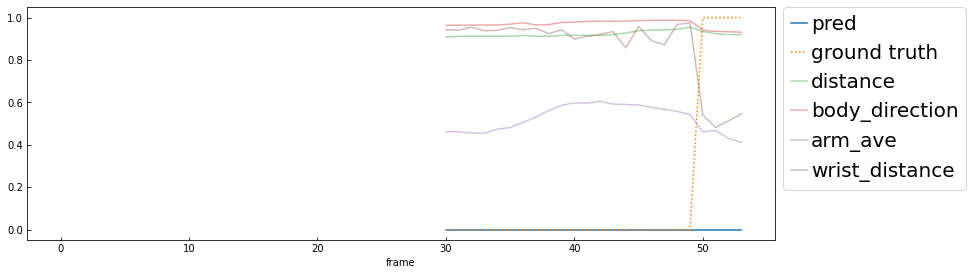

08_001_01_3_6


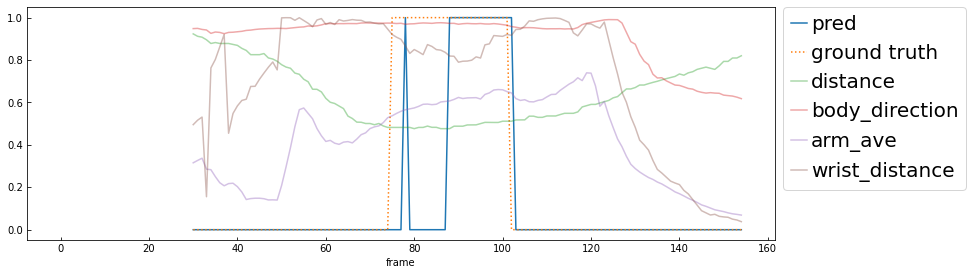

08_001_37_388_389


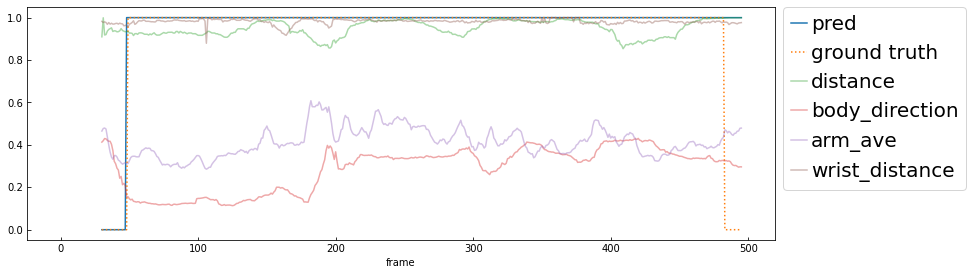

09_001_02_18_29


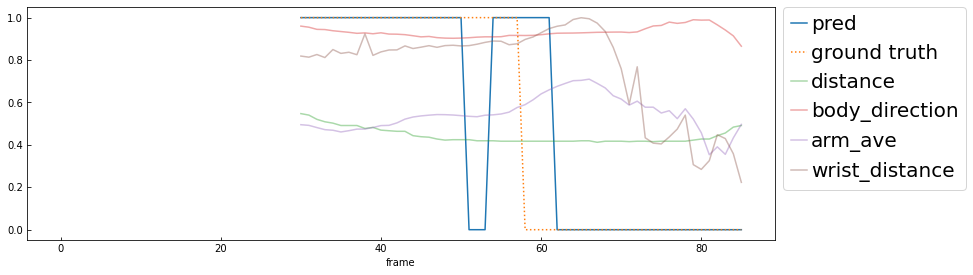

09_001_02_29_18


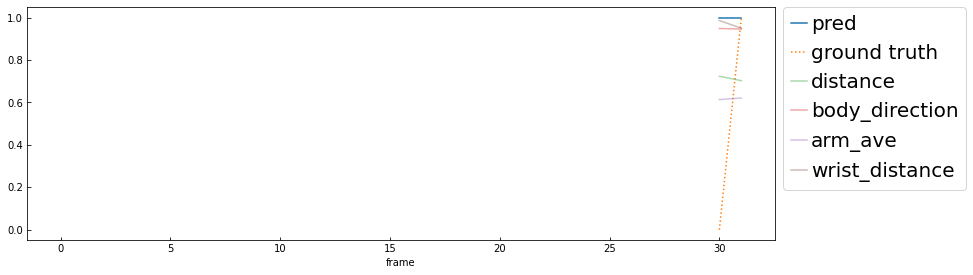

02_001_22_289_295


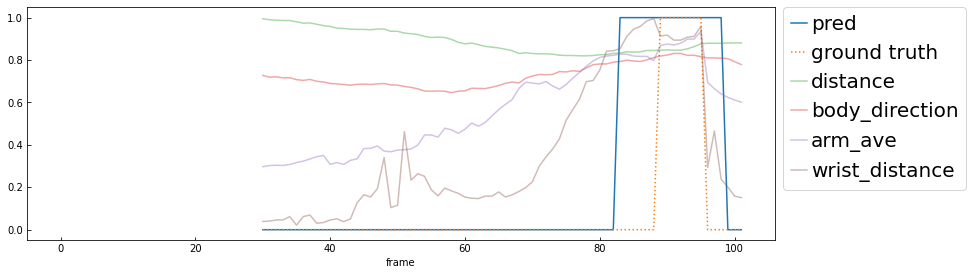

02_001_06_58_61


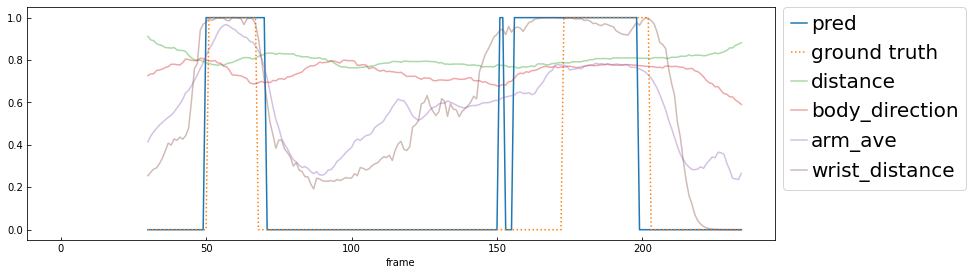

02_001_18_247_251


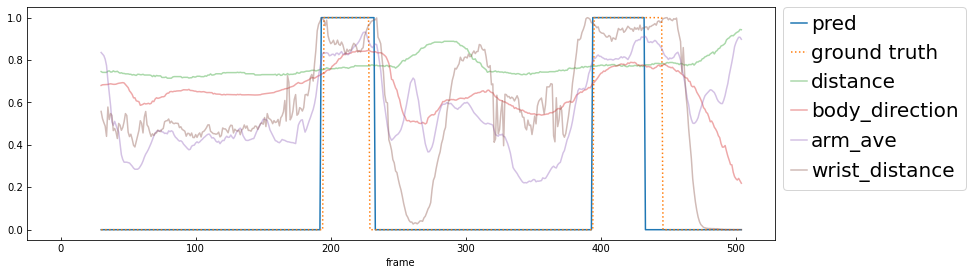

09_001_01_1_8


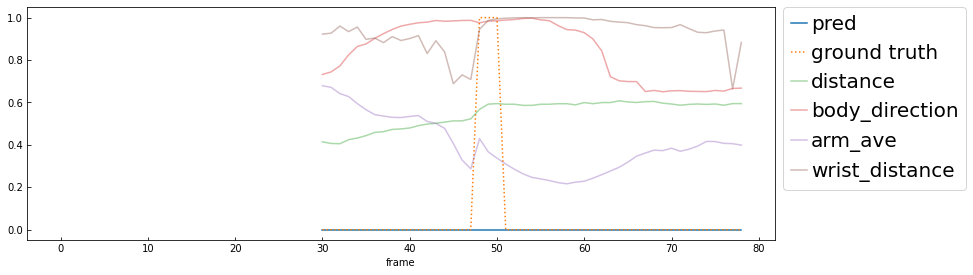

02_001_04_43_42


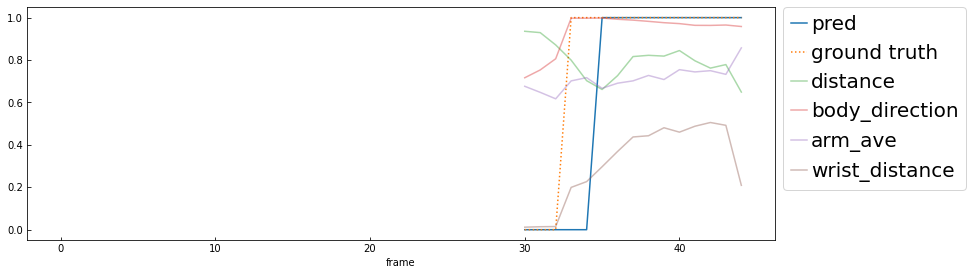

09_001_07_92_96


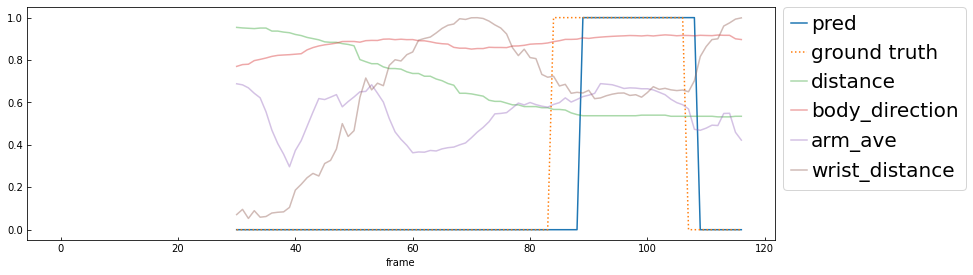

09_001_01_8_1


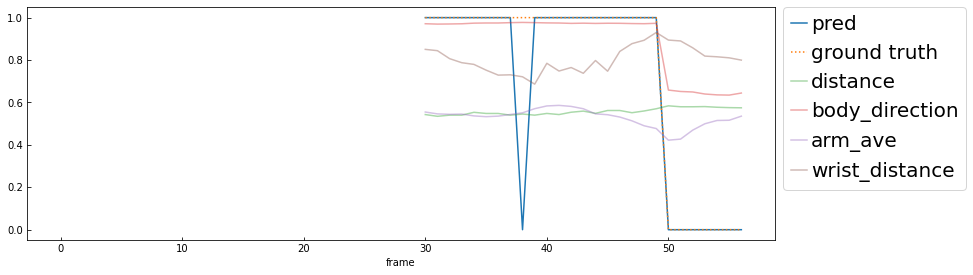

02_001_20_268_270


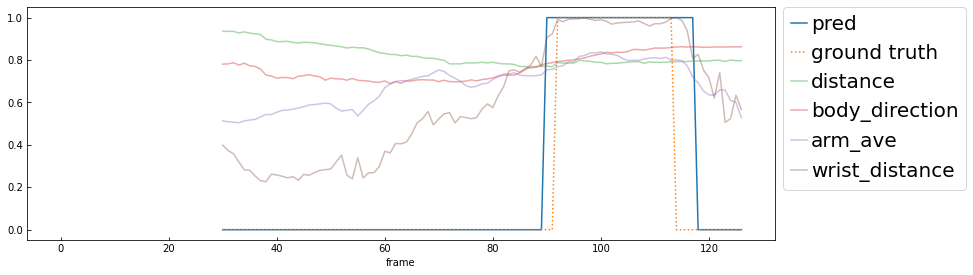

02_001_02_10_11


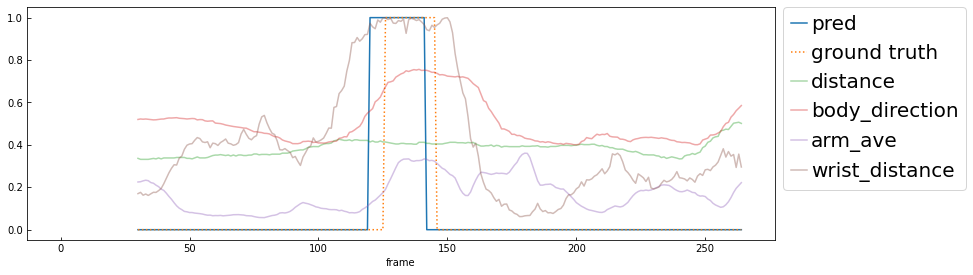

02_001_10_125_119


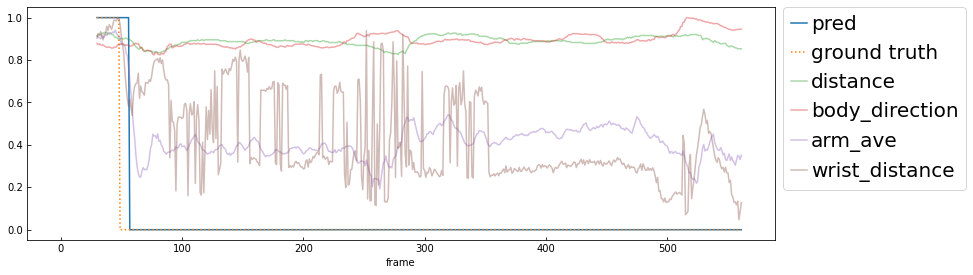

08_001_04_39_41


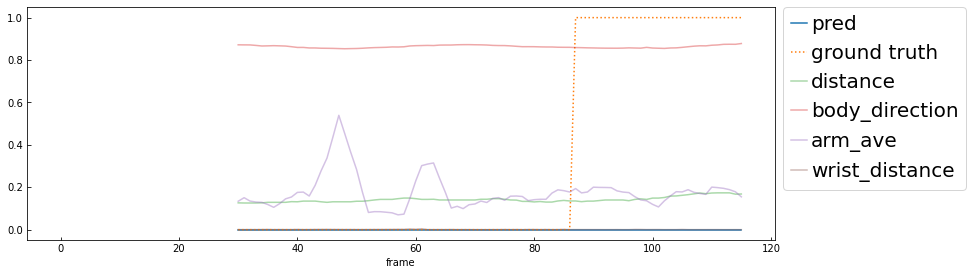

09_001_09_114_116


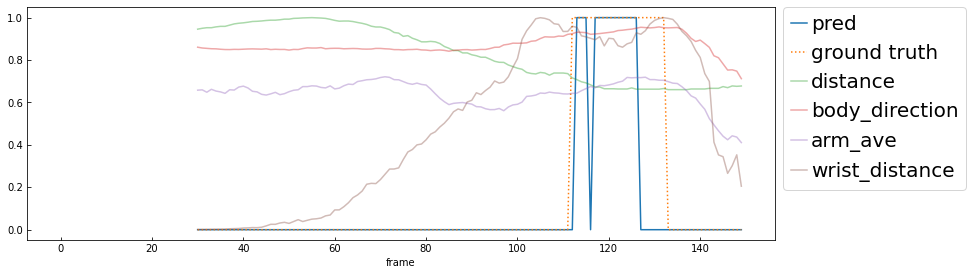

08_001_07_68_70


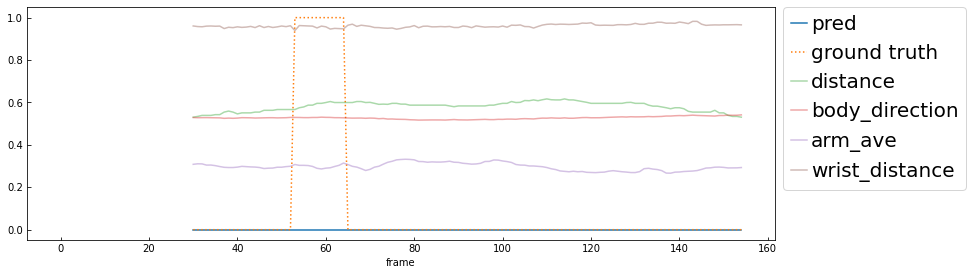

09_001_03_40_45


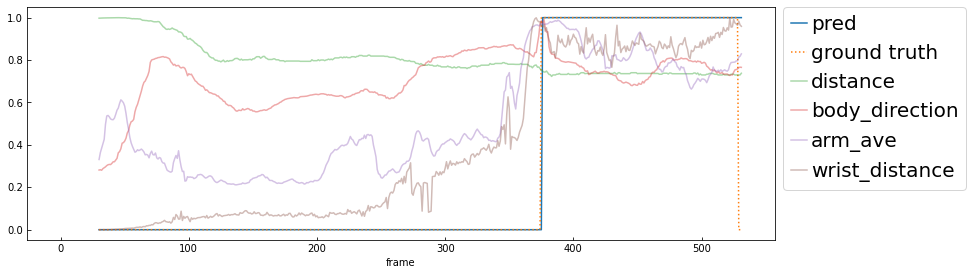

02_001_21_288_287


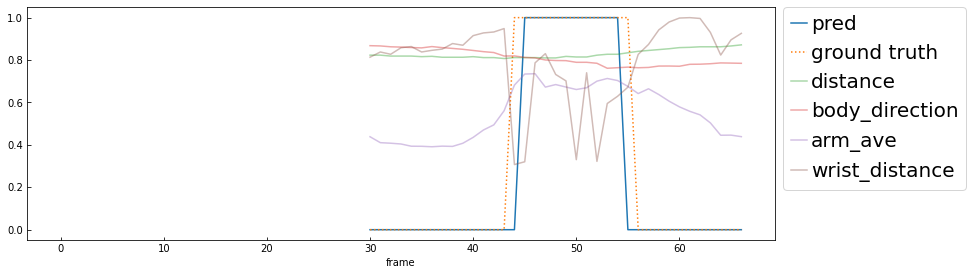

02_001_23_304_309


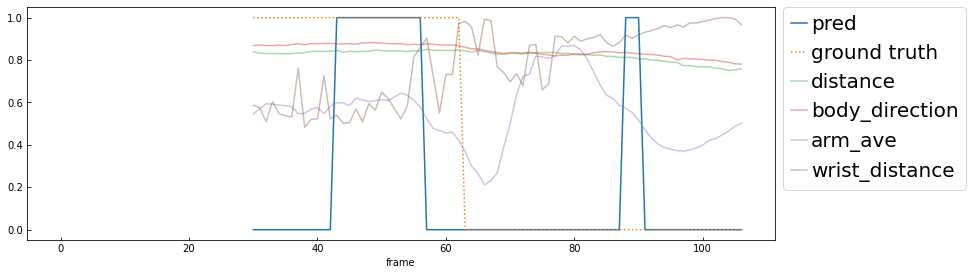

02_001_02_10_13


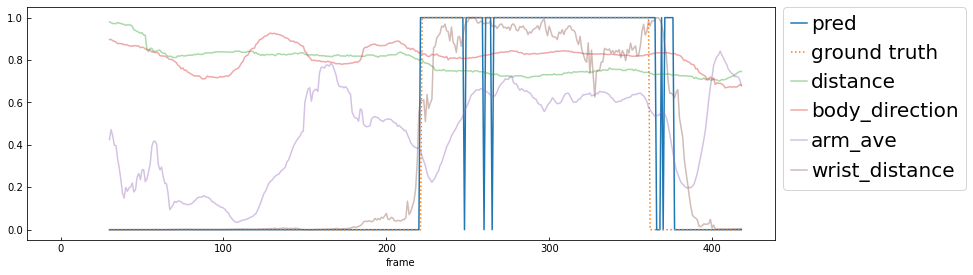

02_001_11_134_140


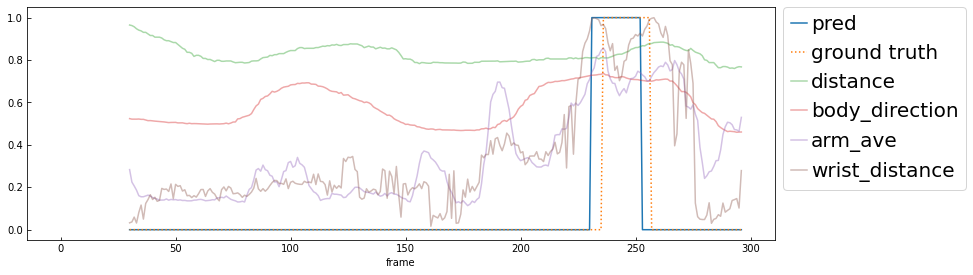

02_001_09_97_104


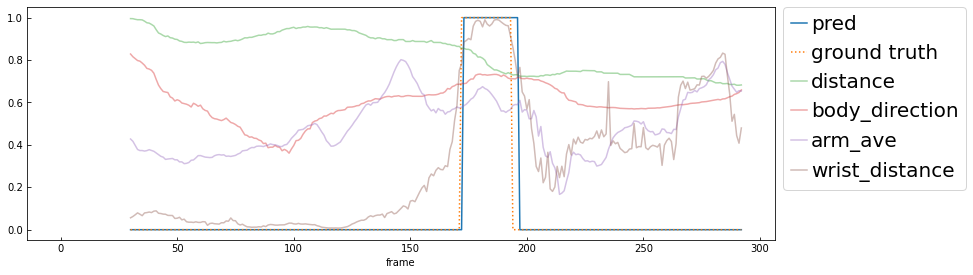

08_001_03_26_32


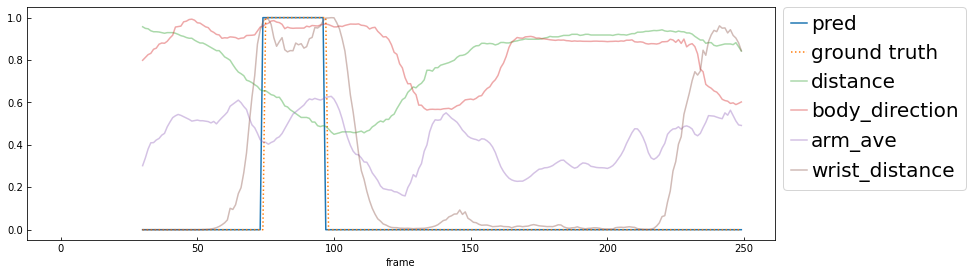

02_001_03_27_31


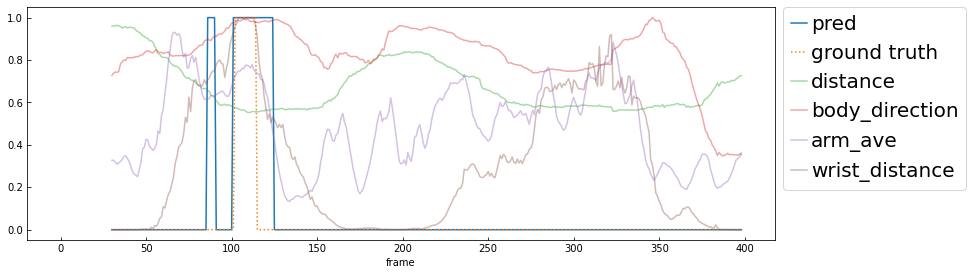

02_001_19_259_262


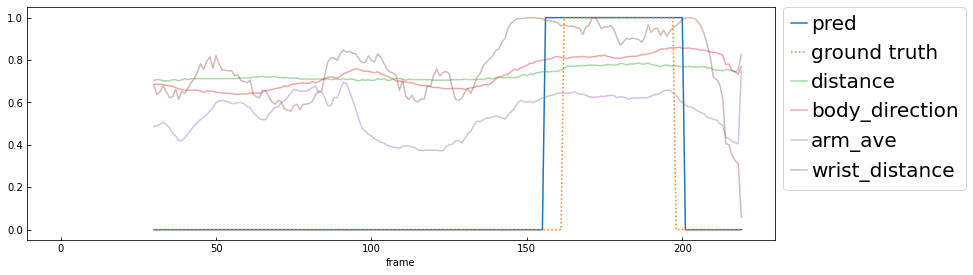

08_001_08_74_75


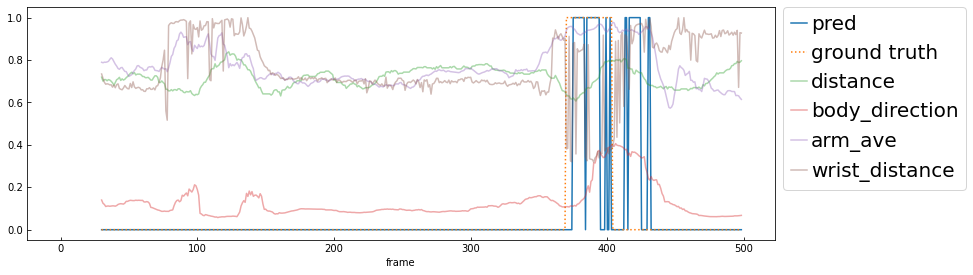

In [95]:
y_all_train = []
pred_all_train = []
y_eve_train = []
pred_eve_train = []

model.eval()
with torch.no_grad():
    for key in train_keys:
        x_lst = np.array(x_dict[key])
        y_lst = y_dict[key]
        
        x, _ = create_sequence(x_lst, y_lst, seq_len, size)
        x = torch.Tensor(x).float().to(device)
        
        if len(x) == 0:
            continue

        pred = model(x)
        pred = pred.max(1)[1]
        pred = pred.cpu().numpy()

        x_lst = x_lst[seq_len - 1:]
        y_lst = y_lst[seq_len - 1:]
            
        y_all_train += y_lst
        pred_all_train += pred.tolist()
        y_eve_train.append(1 in y_lst)
        pred_eve_train.append(1 in pred.tolist())
        
        if 1 not in y_lst:
            continue
            
        print(key)
        path = None
        if key in save_keys:
            path = os.path.join("data", "image", "passing", f"rnn_test_{key}.pdf")
        plot(x_lst, y_lst, pred, seq_len, path=path)

In [96]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_train, pred_all_train)))
print('precision: {:.3f}'.format(precision_score(y_all_train, pred_all_train)))
print('recall: {:.3f}'.format(recall_score(y_all_train, pred_all_train)))
print('f1_score: {:.3f}'.format(f1_score(y_all_train, pred_all_train)))

accuracy: 0.996
precision: 0.584
recall: 0.889
f1_score: 0.705


In [97]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_train, pred_eve_train)))
print('precision: {:.3f}'.format(precision_score(y_eve_train, pred_eve_train)))
print('recall: {:.3f}'.format(recall_score(y_eve_train, pred_eve_train)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_train, pred_eve_train)))

accuracy: 0.960
precision: 0.240
recall: 0.857
f1_score: 0.375


## テストデータ

In [98]:
save_keys = [
    '08_03_2_5',
]

08_001_09_91_89


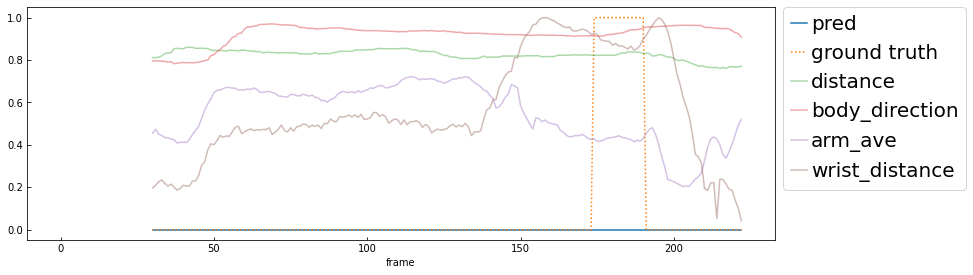

09_001_06_82_85


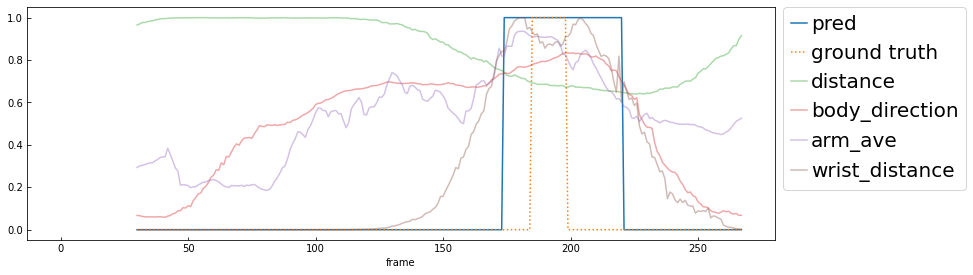

02_001_15_202_204


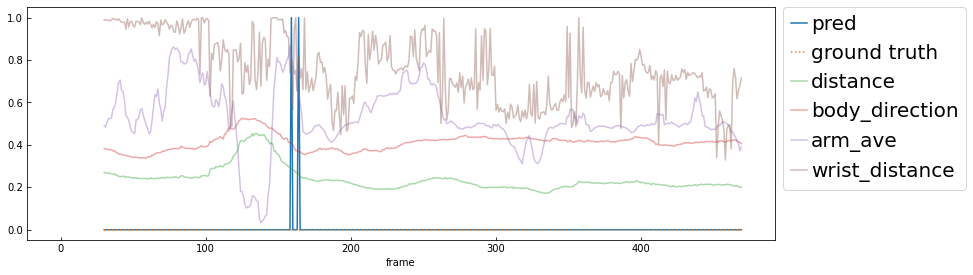

08_001_08_75_76


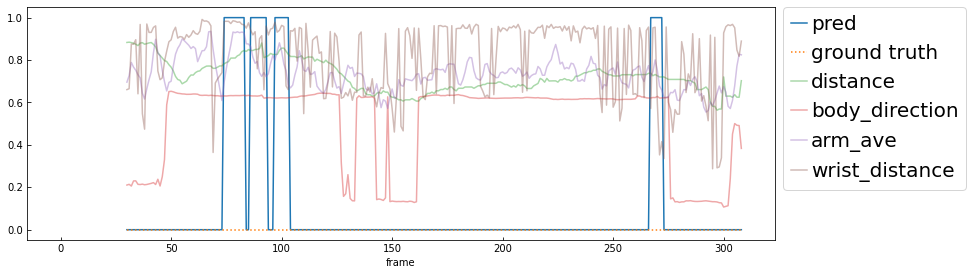

02_001_15_191_202


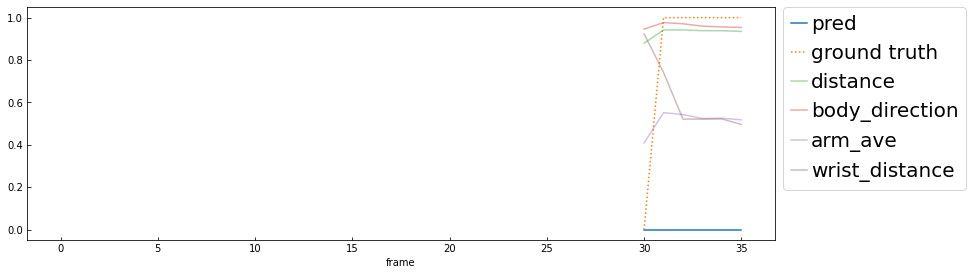

09_001_03_45_41


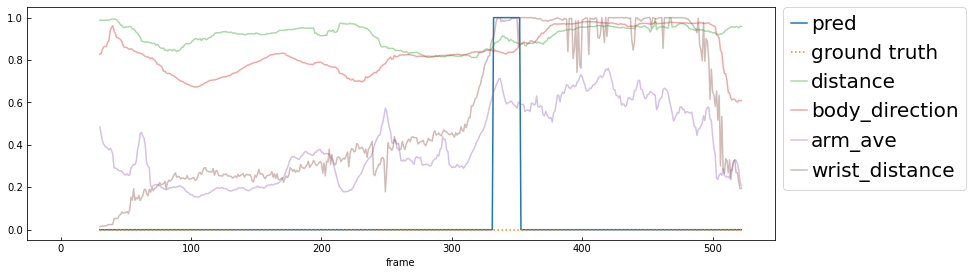

08_001_26_272_275


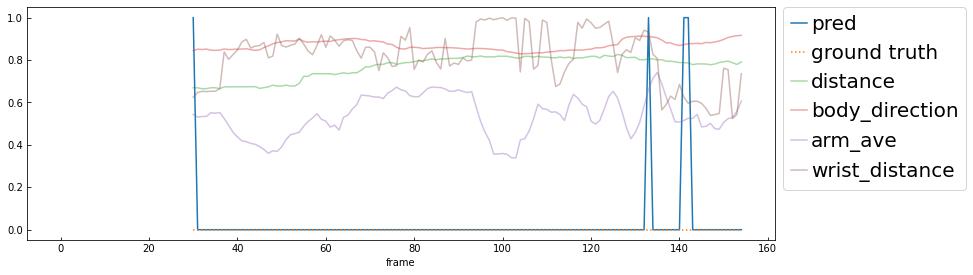

02_001_05_47_51


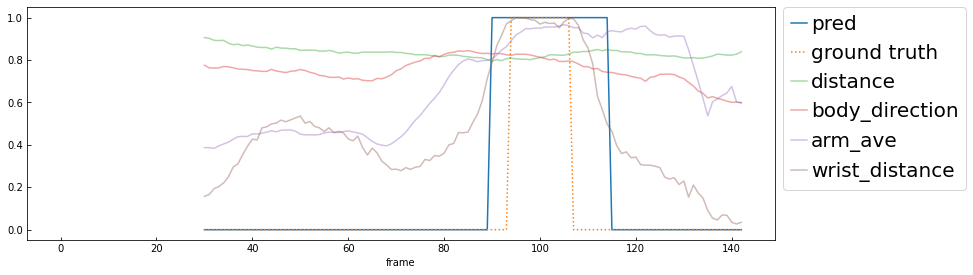

09_001_08_102_105


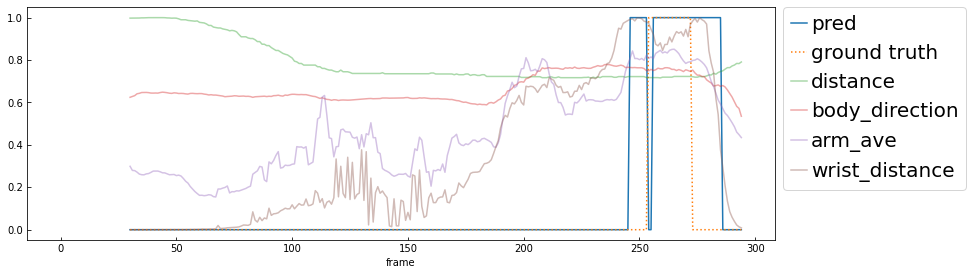

08_001_36_378_380


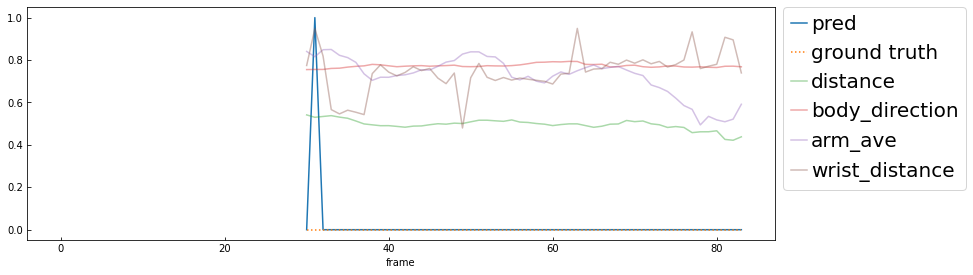

02_001_11_138_141


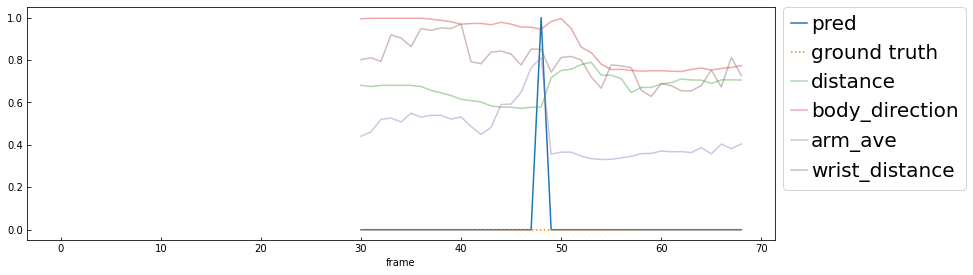

08_001_04_42_43


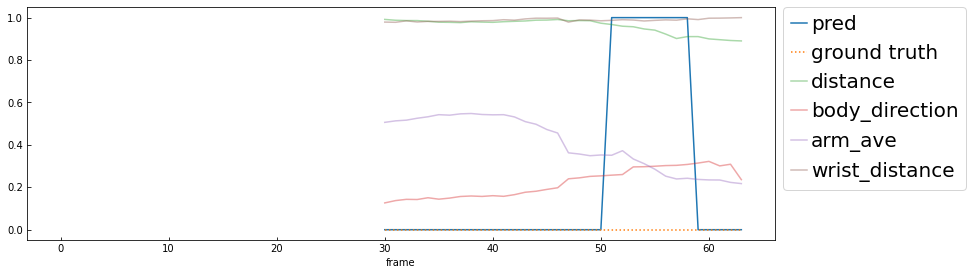

02_001_10_121_122


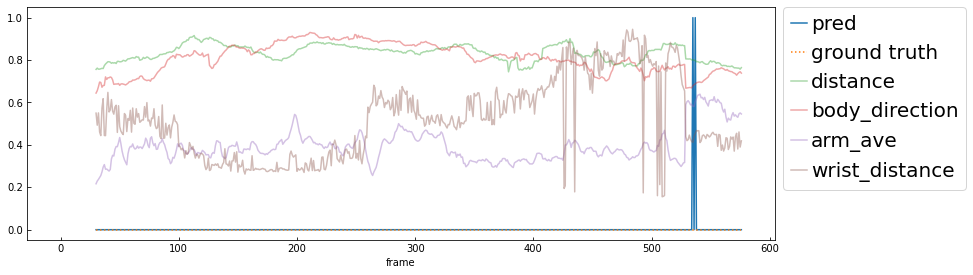

02_001_13_166_167


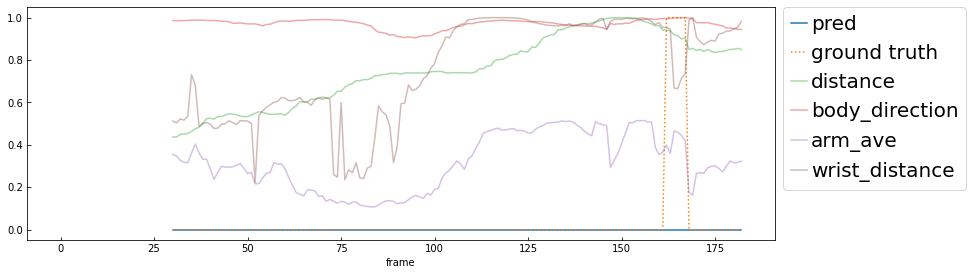

08_001_05_49_48


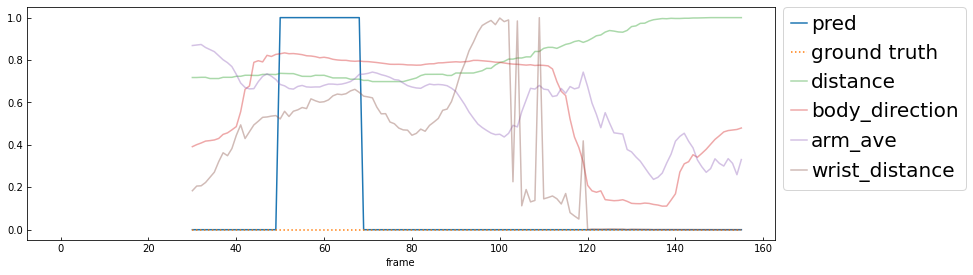

08_001_11_111_114


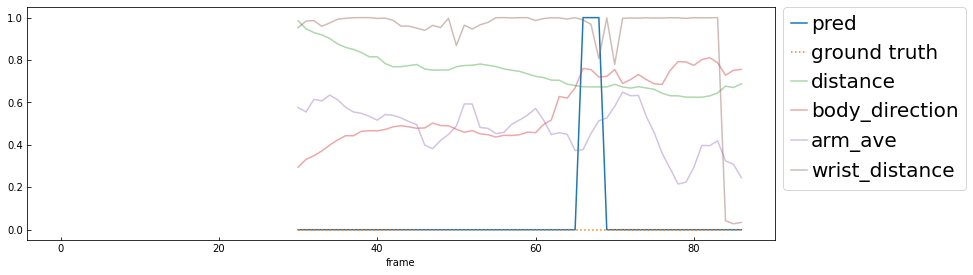

02_001_20_268_266


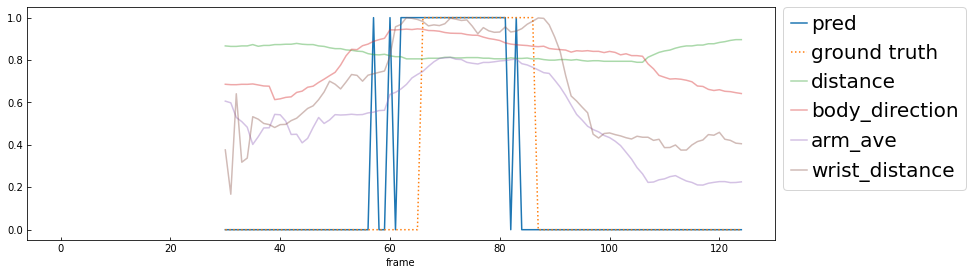

08_001_10_97_99


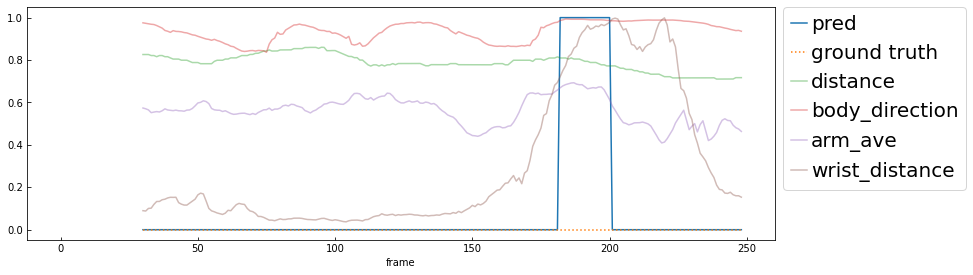

08_001_36_378_381


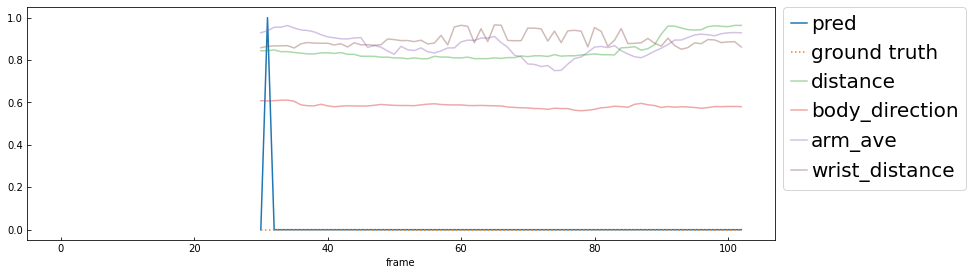

08_001_10_98_100


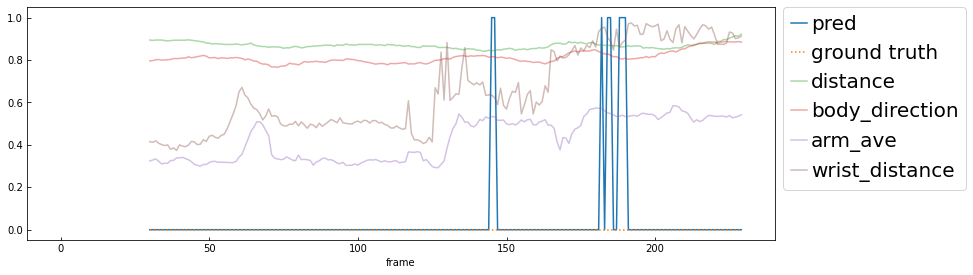

08_001_30_316_317


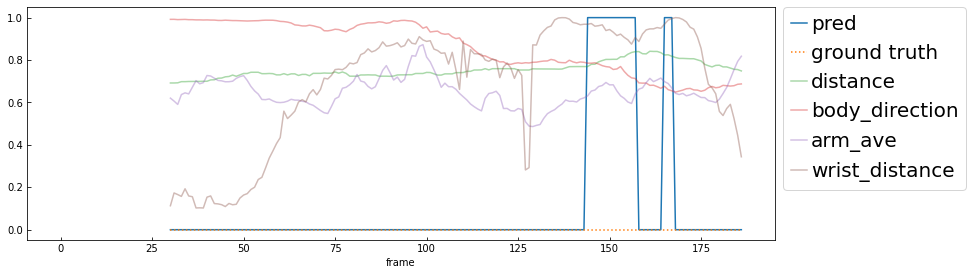

08_001_03_26_28


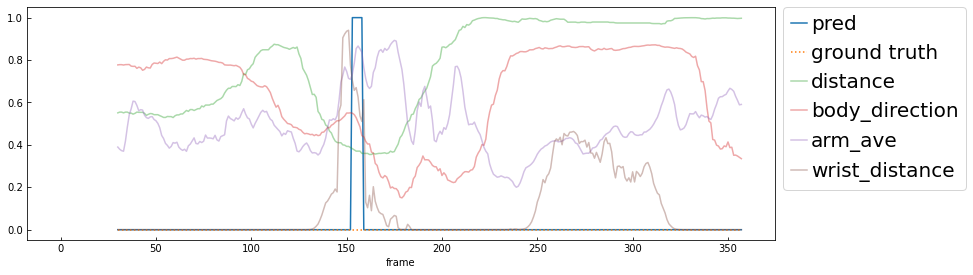

09_001_04_60_59


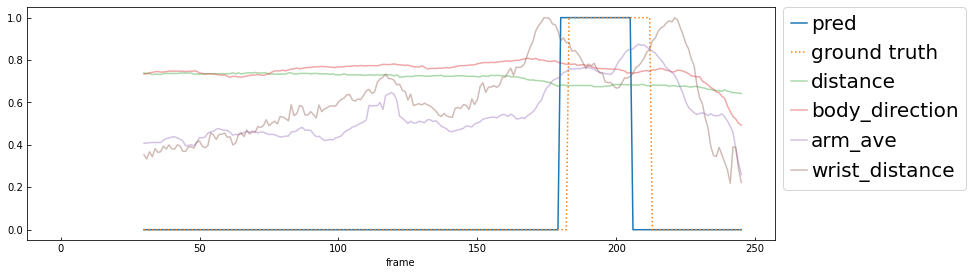

02_001_08_81_85


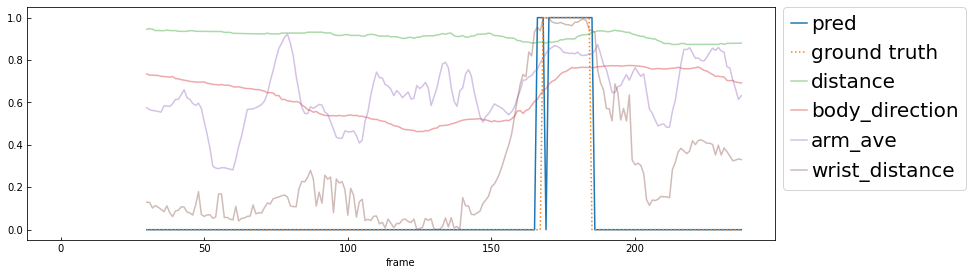

08_001_24_247_253


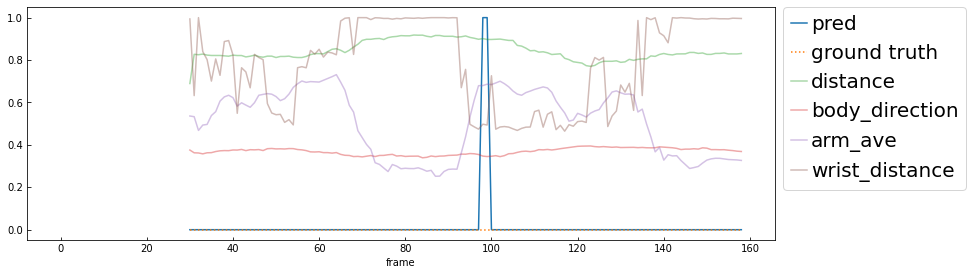

In [99]:
y_all_test = []
pred_all_test = []
y_eve_test = []
pred_eve_test = []
tn, fn = 0, 0

model.eval()
with torch.no_grad():
    for key in test_keys:
        x_lst = np.array(x_dict[key])
        y_lst = y_dict[key]

        x, _ = create_sequence(x_lst, y_lst, seq_len, size)
        x = torch.Tensor(x).float().to(device)

        if len(x) == 0:
            tn += 1
            continue
            
        pred = model(x)
        pred = pred.max(1)[1]
        pred = pred.cpu().numpy()

        x_lst = x_lst[seq_len - 1:]
        y_lst = y_lst[seq_len - 1:]
        
        y_all_test += y_lst
        pred_all_test += pred.tolist()
        y_eve_test.append(1 in y_lst)
        pred_eve_test.append(1 in pred.tolist())
        if 1 not in y_lst:
            if 1 not in pred:
                tn += 1
            else:
                fn += 1
        
        if 1 not in pred and 1 not in y_lst:
            continue
            
        print(key)
        path = None
        if key in save_keys:
            path = os.path.join(common.data_dir, "image", "passing", f"rnn_test_{key}.pdf")
        plot(x_lst, y_lst, pred, seq_len, path=path)

accuracy: 0.995
precision: 0.310
recall: 0.704
f1_score: 0.430


<AxesSubplot:>

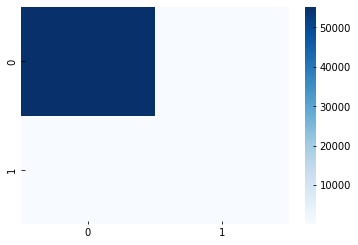

In [100]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_test, pred_all_test)))
print('precision: {:.3f}'.format(precision_score(y_all_test, pred_all_test)))
print('recall: {:.3f}'.format(recall_score(y_all_test, pred_all_test)))
print('f1_score: {:.3f}'.format(f1_score(y_all_test, pred_all_test)))

cm = confusion_matrix(y_all_test, pred_all_test)
sns.heatmap(cm, cmap='Blues')

accuracy: 0.962
precision: 0.273
recall: 0.667
f1_score: 0.387
true negative: 986
false negative: 16


<AxesSubplot:>

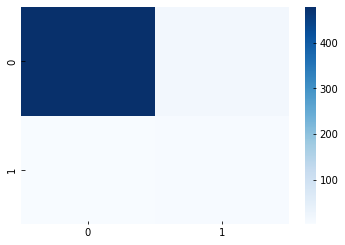

In [101]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_test, pred_eve_test)))
print('precision: {:.3f}'.format(precision_score(y_eve_test, pred_eve_test)))
print('recall: {:.3f}'.format(recall_score(y_eve_test, pred_eve_test)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_test, pred_eve_test)))

print('true negative:', tn)
print('false negative:', fn)

cm = confusion_matrix(y_eve_test, pred_eve_test)
sns.heatmap(cm, cmap='Blues')